 Device: cuda:0
example_data.shape: torch.Size([1000, 1, 28, 28])
Devico for CNN: cuda:0
Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3096, Accuracy: 1206/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307517
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.246306
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.289309
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.234078
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.155736
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.165020
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.119678
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.022820
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.987808
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.821059
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.813160
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.740298
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.592744
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.514969
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.480111
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.387264
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.503582
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.233170
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.566584
Train Epoch: 1 [12160

RuntimeError: Mismatched Tensor types in NNPack convolutionOutput

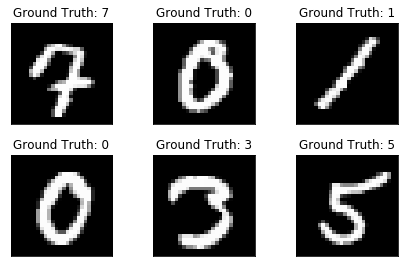

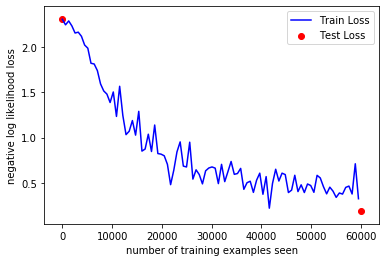

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms

n_epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1

torch.set_default_tensor_type(torch.cuda.FloatTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(" Device:",device)


torch.backends.cudnn.enabled  = True
torch.backends.cudnn.benchmark =True
torch.manual_seed(random_seed)



train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/home/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/home/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)
  
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print("example_data.shape:",example_data.shape)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = Net()
print("Devico for CNN:",device)
network=network.to(device)
print(network)

optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data=data.cuda()
    target=target.cuda()
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/home/files/model.pth')
      torch.save(optimizer.state_dict(), '/home/files/optimizer.pth')


def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data=data.cuda()
      target=target.cuda()
      output = network(data)
      output=output.cuda()
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
	
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
  
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig  


#with torch.no_grad():
#  output = network(example_data)

#fig = plt.figure()
#for i in range(6):
#  plt.subplot(2,3,i+1)
#  plt.tight_layout()
#  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#  plt.title("Prediction: {}".format(
#    output.data.max(1, keepdim=True)[1][i].item()))
#  plt.xticks([])
#  plt.yticks([])
#fig
